## Previsão Ibovespa
Esse notebook tem como objetivo realizar a previsão do índice IBovespa utilizando alguns modelos de Machine Learning. Esse projeto foi realizado como parte da Fase 2 da pós graduação em Data Analytics da POSTECH FIAP.

### 1. Entendimento do Negócio
O problema
Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Você precisará demonstrar para o time de investimentos:
1. O modelo com o storytelling, desde a captura do dado até a entrega do
modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%)

### 2. Entendimento dos Dados
Para isso, utilize a base de dados contida no site da Investing https://br.investing.com/indices/bovespa-historical-data) e selecione o período “diário”, com o intervalo de tempo que achar adequado.

Testaremos alguns períodos Históricos para treinamento com uso de 180 dias anteriores para previsão.

In [92]:
!pip install requests beautifulsoup4 pandas

^C


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [93]:
# web scraping
url = "https://br.investing.com/indices/bovespa-historical-data"
response = requests.get(url)

In [5]:
soup = BeautifulSoup(response.content, 'html.parser')

In [94]:
c

In [20]:
# Encontrar os cabeçalhos
headers = [th.text for th in table.find_all('th')]

In [95]:
# Encontrar os dados
data = []
for row in table.find_all('tr'):
    cols = row.find_all('td')
    data.append([col.text for col in cols])

In [86]:
# Imprimir os resultados
print("Cabeçalhos:", headers)
print("Dados Atuais:")
for row in data:
    print(row)

Cabeçalhos: ['', '', '', '', '', '', '']
Dados Atuais:
[]
['10.01.2025', '118.856', '119.781', '120.052', '118.732', '9,26M', '-0.77%']
['09.01.2025', '119.781', '119.625', '120.145', '119.502', '6,61M', '+0.13%']
['08.01.2025', '119.625', '121.160', '121.160', '119.351', '10,23M', '-1.27%']
['07.01.2025', '121.163', '120.022', '121.713', '120.022', '11,12M', '+0.95%']
['06.01.2025', '120.022', '118.534', '120.322', '118.534', '9,69M', '+1.26%']
['03.01.2025', '118.533', '120.125', '120.356', '118.404', '9,80M', '-1.33%']
['02.01.2025', '120.125', '120.283', '120.782', '119.120', '9,37M', '-0.13%']
['30.12.2024', '120.283', '120.267', '121.050', '120.158', '8,90M', '+0.01%']
['27.12.2024', '120.269', '121.078', '121.609', '120.252', '8,94M', '-0.67%']
['26.12.2024', '121.078', '120.767', '121.612', '120.428', '8,34M', '+0.26%']
['23.12.2024', '120.767', '122.105', '122.105', '120.617', '9,95M', '-1.09%']
['20.12.2024', '122.102', '121.183', '122.209', '120.700', '18,13M', '+0.75%']
['1

In [87]:
df = pd.DataFrame(data, columns=['Data','Último','Abertura','Máxima','Mínima','Vol.', 'Var%'])

In [97]:
df = df.drop(index=0)

In [98]:
df.head(3)

Data   Último Abertura   Máxima   Mínima    Vol.    Var%
1  10.01.2025  118.856  119.781  120.052  118.732   9,26M  -0.77%
2  09.01.2025  119.781  119.625  120.145  119.502   6,61M  +0.13%
3  08.01.2025  119.625  121.160  121.160  119.351  10,23M  -1.27%

In [78]:
df.shape

(19, 7)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [99]:
url = 'https://raw.githubusercontent.com/Data-Analitycs-Pos-Tech-Fiap/Ibovespa-prev/refs/heads/main/datasets/Dados%20Hist%C3%B3ricos%20-%20Ibovespa%202000%20a%202025.csv'

dados_030125 = pd.read_csv(url, sep=',', encoding='utf-8')

dados_030125.head(3)

Data   Último  Abertura   Máxima   Mínima   Vol.    Var%
0  03.01.2025  118.533   120.125  120.356  118.404  9,80B  -1,33%
1  02.01.2025  120.125   120.283  120.782  119.120  9,37B  -0,13%
2  30.12.2024  120.283   120.267  121.050  120.158  8,90B   0,01%

In [38]:
# compreendendo os tipos de dados e o shape da base
print(dados_030125.info())
print('----------------------------------------------------')
print('TAMANHO DA BASE: ', dados_030125.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4954 non-null   object 
 1   Último    4954 non-null   float64
 2   Abertura  4954 non-null   float64
 3   Máxima    4954 non-null   float64
 4   Mínima    4954 non-null   float64
 5   Vol.      4953 non-null   object 
 6   Var%      4954 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.0+ KB
None
----------------------------------------------------
TAMANHO DA BASE:  (4954, 7)


In [100]:
# Concatenando os DataFrames verticalmente
df_concatenado = pd.concat([df, dados_030125], ignore_index=True)

print(df_concatenado)

            Data   Último Abertura   Máxima   Mínima     Vol.    Var%
0     10.01.2025  118.856  119.781  120.052  118.732    9,26M  -0.77%
1     09.01.2025  119.781  119.625  120.145  119.502    6,61M  +0.13%
2     08.01.2025  119.625  121.160  121.160  119.351   10,23M  -1.27%
3     07.01.2025  121.163  120.022  121.713  120.022   11,12M  +0.95%
4     06.01.2025  120.022  118.534  120.322  118.534    9,69M  +1.26%
...          ...      ...      ...      ...      ...      ...     ...
4968  10.01.2005   24.292   24.747   24.825   24.086  126,23M  -1,84%
4969  07.01.2005   24.747   24.376   24.874   24.376  104,96M   1,56%
4970  06.01.2005   24.367   24.695   24.808    24.25  151,17M  -1,32%
4971  05.01.2005   24.692   24.859   25.001   24.523  127,42M  -0,63%
4972  04.01.2005   24.848   25.722   25.873   24.791  146,14M  -3,40%

[4973 rows x 7 columns]


In [101]:
# Verificando duplicidades na coluna 'Data'
duplicados = df_concatenado['Data'].duplicated()
print(duplicados)
# Contando o número de duplicatas
print(duplicados.sum())

0       False
1       False
2       False
3       False
4       False
        ...  
4968    False
4969    False
4970    False
4971    False
4972    False
Name: Data, Length: 4973, dtype: bool
14


In [89]:
# Removendo as linhas duplicadas e atribuindo o resultado a um novo DataFrame
df_sem_duplicadas = df_concatenado.drop_duplicates(subset='Data', keep='first')

In [81]:
df_sem_duplicadas.head(3)

Data   Último Abertura   Máxima   Mínima    Vol.    Var%
0  10.01.2025  118.856  119.781  120.052  118.732   9,26M  -0.77%
1  09.01.2025  119.781  119.625  120.145  119.502   6,61M  +0.13%
2  08.01.2025  119.625  121.160  121.160  119.351  10,23M  -1.27%

In [102]:
# Verificando duplicidades na coluna 'Data'
duplicados2 = df_sem_duplicadas['Data'].duplicated()
print(duplicados2)
# Contando o número de duplicatas
print(duplicados2.sum())

0       False
1       False
2       False
3       False
4       False
        ...  
4968    False
4969    False
4970    False
4971    False
4972    False
Name: Data, Length: 4959, dtype: bool
0


In [90]:
dados = df_sem_duplicadas

In [103]:
dados.head()

Data   Último Abertura   Máxima   Mínima    Vol.    Var%
0  10.01.2025  118.856  119.781  120.052  118.732   9,26M  -0.77%
1  09.01.2025  119.781  119.625  120.145  119.502   6,61M  +0.13%
2  08.01.2025  119.625  121.160  121.160  119.351  10,23M  -1.27%
3  07.01.2025  121.163  120.022  121.713  120.022  11,12M  +0.95%
4  06.01.2025  120.022  118.534  120.322  118.534   9,69M  +1.26%

In [65]:
dados.columns

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')

In [70]:
# Teste para ver como estão os dados no Excel
#dados.to_excel('dados_ibovespa.xlsx', index=False)

In [72]:
# Verificar valores ausentes
print(dados.isnull().sum())

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64


In [73]:
# Tratar valores ausentes
dados.fillna(method='ffill', inplace=True)

<ipython-input-73-d9c7bd2e4495>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados.fillna(method='ffill', inplace=True)


In [74]:
# Converter coluna de datas (se necessário)
dados['Data'] = pd.to_datetime(dados['Data'])

In [68]:
# Convertendo a coluna 'Data' para datetime
#dados.index = pd.to_datetime(dados.index, format='%d.%m.%Y')

# Ordenar o índice em ordem crescente
#dados = dados.sort_index()

#dados = dados.asfreq('D', method='pad')
#dados.reset_index(inplace=True)

# preenchendo o restante das colunas com o último valor válido
#for column in dados.columns:
#    dados[column].fillna(dados[column].iloc[-1], inplace=True)

# verificando o resultado
#dados.head(10)


<ipython-input-68-6b188457c7c1>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados[column].fillna(dados[column].iloc[-1], inplace=True)


Data  Último Abertura  Máxima  Mínima     Vol.    Var%
0 2005-01-04  24.848   25.722  25.873  24.791  146,14M  -3,40%
1 2005-01-05  24.692   24.859  25.001  24.523  127,42M  -0,63%
2 2005-01-06  24.367   24.695  24.808   24.25  151,17M  -1,32%
3 2005-01-07  24.747   24.376  24.874  24.376  104,96M   1,56%
4 2005-01-08  24.747   24.376  24.874  24.376  104,96M   1,56%
5 2005-01-09  24.747   24.376  24.874  24.376  104,96M   1,56%
6 2005-01-10  24.292   24.747  24.825  24.086  126,23M  -1,84%
7 2005-01-11   24.37   24.295  24.457  24.127  111,40M   0,32%
8 2005-01-12   24.51    24.37   24.56  23.983  107,12M   0,57%
9 2005-01-13  24.806   24.523  24.919  24.523   91,08M   1,21%

In [75]:
# Configurar índice
dados.set_index('Data', inplace=True)

In [ ]:
# incluindo coluna categórica
dados['unique_id'] = 'ibovespa'

In [ ]:
# renomeando colunas
dados = dados.rename(columns={'Data': 'ds', 'Último': 'y'})
# selecionando colunas
dados = dados[['ds', 'y', 'unique_id']]
dados.head(10)

ds        y unique_id
0 2024-07-04  126.164  ibovespa
1 2024-07-05  126.267  ibovespa
2 2024-07-06  126.267  ibovespa
3 2024-07-07  126.267  ibovespa
4 2024-07-08  126.548  ibovespa
5 2024-07-09  127.108  ibovespa
6 2024-07-10  127.218  ibovespa
7 2024-07-11  128.294  ibovespa
8 2024-07-12  128.897  ibovespa
9 2024-07-13  128.897  ibovespa

In [ ]:
# df com data como índice e valores só coluna y
df1 = dados[['ds', 'y']]
df1 = dados.set_index('ds')

In [ ]:
dados.head(1)

ds        y unique_id
0 2024-07-04  126.164  ibovespa

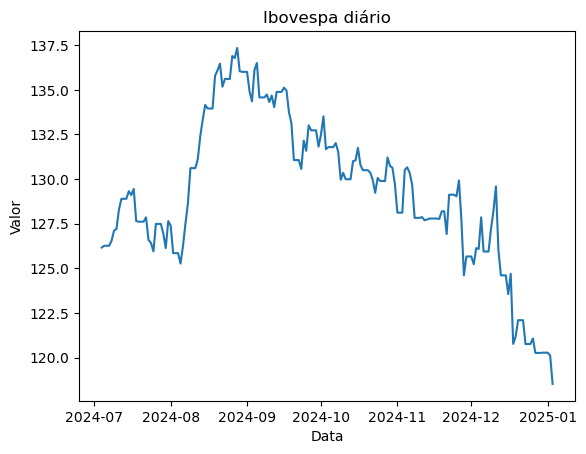

In [ ]:
plt.plot(df1.index, df1["y"])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Ibovespa diário')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
resultados = seasonal_decompose(df1['y'], model='additive', period=1)


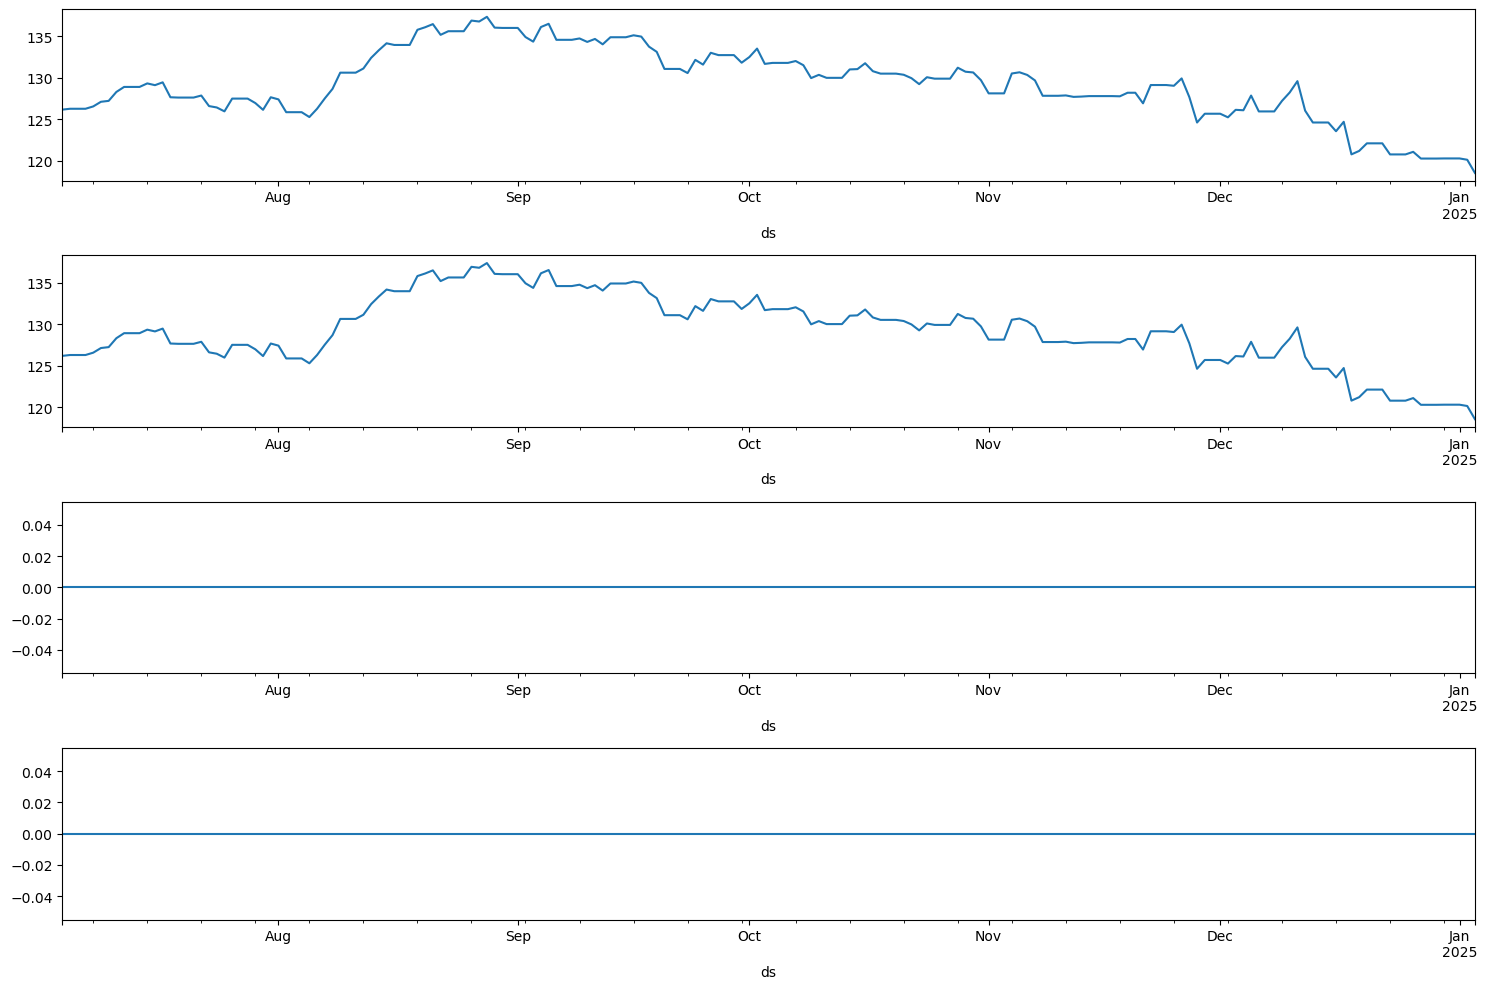

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# mostrando a série do data frame
resultados.observed.plot(ax=ax1)
# mostrando a tendência dos dados
resultados.trend.plot(ax=ax2)
# mostrando a sazonalidade - constante e recorrente
resultados.seasonal.plot(ax=ax3)
# mostrando os resíduos
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
X = df1.y.values

In [ ]:
result = adfuller(X)

# como o teste estatístico é maior que os valores críticos e temos um p-value alto, descartamos a hipótese de série estacionária

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -0.5046569735253487
P-Value: 0.8911045109775122
Valores críticos:
	1%: -3.466598080268425
	5%: -2.8774669520682674
	10%: -2.5752604356654425


In [ ]:
df1.shape

(184, 2)

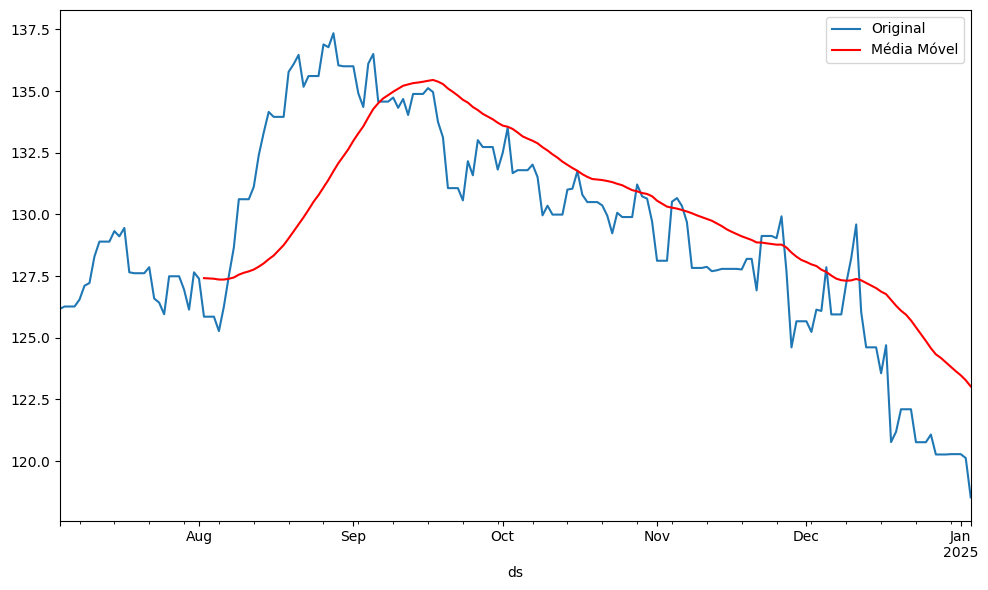

In [ ]:
# Calcular média móvel com janela menor
ma = df1['y'].rolling(window=30).mean()

# Criar o gráfico
f, ax = plt.subplots(figsize=(10,6))
df1['y'].plot(ax=ax, label='Original')
ma.plot(ax=ax, color='r', label='Média Móvel')
plt.legend()
plt.tight_layout()




In [ ]:
# Verificar o DataFrame df1
print("Informações do DataFrame:")
print(df1.info())
print("\nPrimeiras linhas do DataFrame:")
print(df1.head())

# Verificar a série da média móvel
print("\nInformações da média móvel:")
print(ma.head())
print("\nVerificar valores nulos na média móvel:")
print(ma.isnull().sum())


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2024-07-04 to 2025-01-03
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          184 non-null    float64
 1   unique_id  184 non-null    object 
dtypes: float64(1), object(1)
memory usage: 4.3+ KB
None

Primeiras linhas do DataFrame:
                  y unique_id
ds                           
2024-07-04  126.164  ibovespa
2024-07-05  126.267  ibovespa
2024-07-06  126.267  ibovespa
2024-07-07  126.267  ibovespa
2024-07-08  126.548  ibovespa

Informações da média móvel:
ds
2024-07-04   NaN
2024-07-05   NaN
2024-07-06   NaN
2024-07-07   NaN
2024-07-08   NaN
Name: y, dtype: float64

Verificar valores nulos na média móvel:
29
